In [ ]:
!pip install datasets
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00


# Intent Detection as a case study

Text based assistance for a company

In [ ]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)#, device="cuda"


In [ ]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

in production there are various factors that we have to keep in mind

1. model performance :
 - how accurate it is
 - test it on well organized test set

2. latnecy:
 - how much time the model take in to response
 - it is tested in a high trafic environment

3. memory:
 - how to deploy model with billion parameter (model that are large in size)


it is very imp to keep this in mind when deploying a transformer model in production

as it is expensive to run it in a cloud
and model worst if it only few request


it is recommeneded to test the model is all the aspect

and optimze it with various techinques

In [ ]:
# Example of how a test class should look

class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):...
    def time_pipeline(self):...
    def compute_size(self):...
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())

        return metrics

In [ ]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

README.md:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [ ]:
sample = clinc['test'][42]
sample


{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [ ]:
intents = clinc["test"].features["intent"]
intents.int2str(sample['intent'])

'transfer'

In [ ]:
import evaluate

accuracy_score = evaluate.load("accuracy")

In [ ]:
def compute_accuracy(self):
    """This overrides the PreformacnecBencmark.compute_accuracy() method"""
    labels, preds = [], []

    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        preds.append(intents.str2int(pred))
        labels.append(example['intent'])

    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

In [ ]:
PerformanceBenchmark.compute_accuracy = compute_accuracy

In [ ]:
# key is the layer name and values are  weights and biases
list(pipe.model.state_dict().keys())[:10]

['bert.embeddings.word_embeddings.weight',
 'bert.embeddings.position_embeddings.weight',
 'bert.embeddings.token_type_embeddings.weight',
 'bert.embeddings.LayerNorm.weight',
 'bert.embeddings.LayerNorm.bias',
 'bert.encoder.layer.0.attention.self.query.weight',
 'bert.encoder.layer.0.attention.self.query.bias',
 'bert.encoder.layer.0.attention.self.key.weight',
 'bert.encoder.layer.0.attention.self.key.bias',
 'bert.encoder.layer.0.attention.self.value.weight']

In [ ]:
import torch
torch.save(pipe.model.state_dict(), "model.pt")

In [ ]:
import torch
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)

    # Calculate size in mb
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete the temp file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

In [ ]:
PerformanceBenchmark.compute_size = compute_size

In [ ]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time

    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 157.885
Latency (ms) - 136.893
Latency (ms) - 138.699


In [ ]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    latencies = []

    # warm up

    for _ in range(3):
        self.pipeline(query)

    # Time run
    for _ in range(100):
        start_time = perf_counter()

        _ = self.pipeline(query)
        latencies.append(perf_counter() - start_time)

    # Run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +/- {time_std_ms:.2f}")
    return {"time_avg_ms":time_avg_ms, "time_std_ms": time_std_ms}

In [ ]:
PerformanceBenchmark.time_pipeline = time_pipeline

In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"])
pb.time_pipeline()


Average latency (ms) - 98.21 +/- 18.93


{'time_avg_ms': 98.20662421999941, 'time_std_ms': 18.93407388189326}

In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Model size (MB) - 418.15
Average latency (ms) - 12.79 +/- 3.04
Accuracy on test set - 0.867


# Knowledge Distillation: A Detailed Explanation

Knowledge Distillation is a model compression technique introduced by Hinton et al. in 2015. It aims to transfer knowledge from a large, complex model (teacher) to a smaller, simpler model (student).

## Key Terminology

1. **Teacher Model**: The large, complex model that has been trained on a task.
2. **Student Model**: The smaller, simpler model that learns from the teacher.
3. **Soft Targets**: Probability distributions output by the teacher model.
4. **Hard Targets**: The actual labels in the dataset.
5. **Temperature**: A hyperparameter used to control the softness of the probability distributions.

## Mathematical Formulation

Let's denote:
- $x$ as the input
- $y$ as the hard target (true label)
- $T$ as the temperature
- $p_t$ as the teacher's output probabilities
- $p_s$ as the student's output probabilities

### Teacher Model

The teacher model's softmax output for class $i$ is:

$$p_t(i|x; T) = \frac{\exp(z_i/T)}{\sum_j \exp(z_j/T)}$$

where $z_i$ are the logits (pre-softmax activations) for class $i$.

### Student Model

The student model is trained to minimize a combination of two loss functions:

1. **Distillation Loss**: This measures how well the student mimics the teacher's soft targets.

   $$L_{KD} = -T^2 \sum_i p_t(i|x; T) \log(p_s(i|x; T))$$

2. **Student Loss**: This measures how well the student predicts the true labels.

   $$L_{CE} = -\sum_i y_i \log(p_s(i|x; T=1))$$

The total loss is a weighted sum of these two:

$$L_{total} = \alpha L_{CE} + (1-\alpha) L_{KD}$$

where $\alpha$ is a hyperparameter balancing the two objectives.

## Process in Detail

1. **Teacher Training**: Train a large model on the task using standard methods.

2. **Soft Target Generation**: Use the teacher to make predictions on a dataset, typically with a high temperature (e.g., T=20) to produce softer probability distributions.

3. **Student Training**: Train the student model to minimize the total loss $L_{total}$. This involves:
   - Matching the teacher's soft targets (distillation loss)
   - Predicting the correct hard targets (student loss)

4. **Fine-tuning**: Optionally, fine-tune the student on the hard targets alone.

## Why It Works

1. **Information Density**: Soft targets provide more information per training example than hard targets. They encode the teacher's learned similarities between classes.

2. **Regularization**: The soft targets act as a regularizer, preventing overfitting to hard labels.

3. **Dark Knowledge**: The relative probabilities of incorrect answers encode valuable information about the task.

## Variations and Extensions

1. **Born-Again Networks**: Use the same architecture for teacher and student, iteratively distilling knowledge.

2. **Multi-teacher Distillation**: Distill knowledge from multiple teacher models.

3. **Online Distillation**: Train teacher and student simultaneously.

4. **Cross-modal Distillation**: Transfer knowledge between models operating on different types of data (e.g., vision to language).

Knowledge Distillation has become a cornerstone technique in model compression and transfer learning, enabling the deployment of powerful models in resource-constrained environments.

In [ ]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args,**kwargs)
        self.alpha = alpha
        self.temperature = temperature



In [ ]:
from transformers import Trainer
import torch.nn as nn
import torch.nn.functional as F


class DistllantionTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def computer_loss(self, model, inputs, return_outputs=False):
        output_stu = model(**inputs)
        loss_ce = output_stu.loss
        logits_stu = output_stu.logits

        with torch.no_grad():
            output_tea = self.teacher_model(**inputs)
            logits_tea = output_tea.logits
        # Kullback-Leibler divergence loss.
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        # |  .. warning::
        # |      :attr:`reduction`\ `= "mean"` doesn't return the true KL divergence value, please use
        # |      :attr:`reduction`\ `= "batchmean"` which aligns with the mathematical definition.

        # One quirk with nn.KLDivLoss() is that it expects the inputs in the form
        # of log probabilities and the labels as normal probabilities.

        soft_prob_tea = F.softmax(logits_tea / self.args.temperature, dim=-1)
        soft_prob_stu = F.log_softmax(logits_stu / self.args.temperature, dim=-1)

        loss_kd = self.args.temperature**2 * loss_fct(soft_prob_stu, soft_prob_tea)

        loss_stu = (self.args.alpha * loss_ce) + (1. - self.args.alpha) * loss_kd

        return (loss_stu, output_stu) if return_outputs else loss_stu


In [ ]:
help(nn.KLDivLoss)

Help on class KLDivLoss in module torch.nn.modules.loss:

class KLDivLoss(_Loss)
 |  KLDivLoss(size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False) -> None
 |  
 |  The Kullback-Leibler divergence loss.
 |  
 |  For tensors of the same shape :math:`y_{\text{pred}},\ y_{\text{true}}`,
 |  where :math:`y_{\text{pred}}` is the :attr:`input` and :math:`y_{\text{true}}` is the
 |  :attr:`target`, we define the **pointwise KL-divergence** as
 |  
 |  .. math::
 |  
 |      L(y_{\text{pred}},\ y_{\text{true}})
 |          = y_{\text{true}} \cdot \log \frac{y_{\text{true}}}{y_{\text{pred}}}
 |          = y_{\text{true}} \cdot (\log y_{\text{true}} - \log y_{\text{pred}})
 |  
 |  To avoid underflow issues when computing this quantity, this loss expects the argument
 |  :attr:`input` in the log-space. The argument :attr:`target` may also be provided in the
 |  log-space if :attr:`log_target`\ `= True`.
 |  
 |  To summarise, this function is roughly equivalent to c

In [ ]:
from transformers import AutoTokenizer
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=['text'])
clinc_enc = clinc_enc.rename_column("intent", "label")#  renamed the intent column to labels so it can be automatically detected by the trainer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:
print(clinc_enc['train']["input_ids"][:1])

[[101, 2054, 3670, 2052, 1045, 2224, 2000, 2360, 1045, 2293, 2017, 2065, 1045, 2020, 2019, 3059, 102]]


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=-1)
    return accuracy_score.compute(predictions=predictions,references=labels)


In [ ]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt,
    evaluation_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=1,
    weight_decay=0.01,
    push_to_hub=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
help(TrainingArguments)

In [ ]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [ ]:
id2label

{0: 'restaurant_reviews',
 1: 'nutrition_info',
 2: 'account_blocked',
 3: 'oil_change_how',
 4: 'time',
 5: 'weather',
 6: 'redeem_rewards',
 7: 'interest_rate',
 8: 'gas_type',
 9: 'accept_reservations',
 10: 'smart_home',
 11: 'user_name',
 12: 'report_lost_card',
 13: 'repeat',
 14: 'whisper_mode',
 15: 'what_are_your_hobbies',
 16: 'order',
 17: 'jump_start',
 18: 'schedule_meeting',
 19: 'meeting_schedule',
 20: 'freeze_account',
 21: 'what_song',
 22: 'meaning_of_life',
 23: 'restaurant_reservation',
 24: 'traffic',
 25: 'make_call',
 26: 'text',
 27: 'bill_balance',
 28: 'improve_credit_score',
 29: 'change_language',
 30: 'no',
 31: 'measurement_conversion',
 32: 'timer',
 33: 'flip_coin',
 34: 'do_you_have_pets',
 35: 'balance',
 36: 'tell_joke',
 37: 'last_maintenance',
 38: 'exchange_rate',
 39: 'uber',
 40: 'car_rental',
 41: 'credit_limit',
 42: 'oos',
 43: 'shopping_list',
 44: 'expiration_date',
 45: 'routing',
 46: 'meal_suggestion',
 47: 'tire_change',
 48: 'todo_list

In [ ]:
from transformers import AutoConfig

num_labels = intents.num_classes

student_config = (
    AutoConfig
    .from_pretrained(student_ckpt, num_lables=num_labels,
                     id2label=id2label, label2id=label2id)
)

In [ ]:
student_ckpt

'distilbert-base-uncased'

In [ ]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (
        AutoModelForSequenceClassification
        .from_pretrained(
            student_ckpt, config=student_config
        ).to(device)
    )

In [ ]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
.from_pretrained(teacher_ckpt, num_labels=num_labels)
.to(device))

In [ ]:
distiltbert_trainer = DistllantionTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc["train"],
    eval_dataset=clinc_enc["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
distiltbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.293084,0.725484
2,3.800900,1.884935,0.852581
3,3.800900,1.170155,0.889677
4,1.712800,0.871707,0.914516
5,0.920600,0.787232,0.920645


TrainOutput(global_step=1590, training_loss=2.0674823641027293, metrics={'train_runtime': 201.8922, 'train_samples_per_second': 377.677, 'train_steps_per_second': 7.875, 'total_flos': 414689637990180.0, 'train_loss': 2.0674823641027293, 'epoch': 5.0})

In [ ]:
distiltbert_trainer.push_to_hub("Training completed!")

events.out.tfevents.1729159087.40ab3aefb7cf.465.10:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aman155/distilbert-base-uncased-finetuned-clinc/commit/9e1114cb510bd77615080fbf5dced51d548fb6f1', commit_message='Training completed!', commit_description='', oid='9e1114cb510bd77615080fbf5dced51d548fb6f1', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# ?accuracy_score.compute

In [ ]:
# accuracy_score.compute(predictions=[1,1], references=[0,1])

In [ ]:
finetuned_ckpt = "aman155/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)#, device="cuda"

In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"])
pb.time_pipeline()

Average latency (ms) - 48.98 +/- 5.83


{'time_avg_ms': 48.977785890003815, 'time_std_ms': 5.825073150478356}

In [ ]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 7.47 +/- 1.79
Accuracy on test set - 0.851


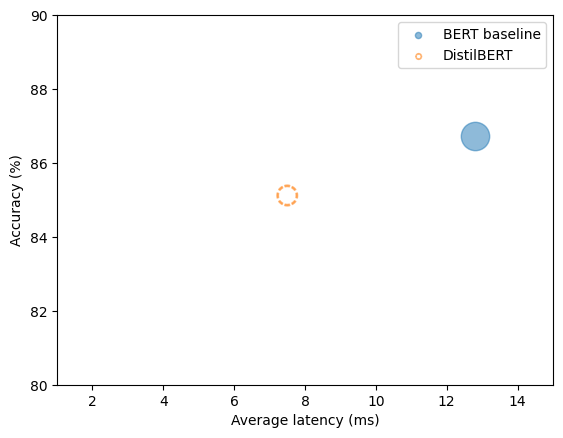

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
            alpha=0.5, s=df_opt["size_mb"], label=idx,
            marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
            s=df_opt["size_mb"], label=idx, alpha=0.5)
        legend = plt.legend(bbox_to_anchor=(1,1))
        for handle in legend.legend_handles:
            handle.set_sizes([20])
            plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
plot_metrics(perf_metrics, optim_type)

## Finding Good Hyperparameters with Optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)

    return (1-x) **2+ 100 * (y-x**2)**2

In [ ]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2024-10-19 10:24:23,846] A new study created in memory with name: no-name-71103f9a-223c-44e9-8dcc-bf9f76aacdb6
[I 2024-10-19 10:24:23,852] Trial 0 finished with value: 630.5824583938286 and parameters: {'x': -1.53511990399923, 'y': -0.14171756051744966}. Best is trial 0 with value: 630.5824583938286.
[I 2024-10-19 10:24:23,861] Trial 1 finished with value: 134.68829279629188 and parameters: {'x': 0.7857686030549051, 'y': 1.7777874057135548}. Best is trial 1 with value: 134.68829279629188.
[I 2024-10-19 10:24:23,867] Trial 2 finished with value: 1532.6664551267675 and parameters: {'x': -1.947406988003301, 'y': -0.11142370218675435}. Best is trial 1 with value: 134.68829279629188.
[I 2024-10-19 10:24:23,872] Trial 3 finished with value: 646.8636146028747 and parameters: {'x': 0.9930850472610131, 'y': -1.5571333560073497}. Best is trial 1 with value: 134.68829279629188.
[I 2024-10-19 10:24:23,875] Trial 4 finished with value: 545.1788280554831 and parameters: {'x': 1.2315259534032377, 

In [ ]:
study.best_params

{'x': 0.9915902843502128, 'y': 0.9842527185549312}

In [ ]:
def hp_space(trial):
    return {
        "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_int("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20),
    }

In [ ]:
best_run = distiltbert_trainer.hyperparameter_search(
    n_trials=10, direction="maximize", hp_space=hp_space
)

[I 2024-10-19 11:22:51,179] A new study created in memory with name: no-name-58d922eb-e9cf-470c-a1d4-e0a844b47406
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▅█
train/global_step,▁▅█
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.86968


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.233023,0.730645
2,3.754800,1.706364,0.861613
3,3.754800,0.929412,0.906774
4,1.497900,0.594968,0.927097
5,0.597600,0.447027,0.935484
6,0.597600,0.389829,0.936774
7,0.324800,0.370520,0.939032


[I 2024-10-19 11:33:41,857] Trial 0 finished with value: 0.9390322580645162 and parameters: {'num_train_epochs': 7, 'alpha': 0, 'temperature': 20}. Best is trial 0 with value: 0.9390322580645162.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇████
eval/loss,█▄▂▂▁▁▁
eval/runtime,█▁▂▁▁▁▁
eval/samples_per_second,▁█▆██▇▇
eval/steps_per_second,▁█▆██▇▇
train/epoch,▁▂▂▃▄▅▅▆▇▇██
train/global_step,▁▂▂▃▄▅▅▆▇▇██
train/grad_norm,█▇▄▁
train/learning_rate,█▆▃▁
train/loss,█▃▂▁
eval/accuracy,0.93903


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.233023,0.730645
2,3.754800,1.706364,0.861613
3,3.754800,0.929412,0.906774
4,1.497900,0.594968,0.927097
5,0.597600,0.447027,0.935484
6,0.597600,0.389829,0.936774
7,0.324800,0.370520,0.939032


[I 2024-10-19 11:40:17,151] Trial 1 finished with value: 0.9390322580645162 and parameters: {'num_train_epochs': 7, 'alpha': 0, 'temperature': 11}. Best is trial 0 with value: 0.9390322580645162.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇████
eval/loss,█▄▂▂▁▁▁
eval/runtime,▁▇▂▂▁█▃
eval/samples_per_second,█▂▇▇█▁▆
eval/steps_per_second,█▂▇▇█▁▆
train/epoch,▁▂▂▃▄▅▅▆▇▇██
train/global_step,▁▂▂▃▄▅▅▆▇▇██
train/grad_norm,█▇▄▁
train/learning_rate,█▆▃▁
train/loss,█▃▂▁
eval/accuracy,0.93903


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.199237,0.732903
2,3.728700,1.612667,0.866774
3,3.728700,0.822086,0.910000
4,1.390600,0.498473,0.931290
5,0.476500,0.358656,0.940645
6,0.476500,0.309486,0.941290
7,0.206600,0.277883,0.944516
8,0.115800,0.266682,0.945484
9,0.115800,0.263994,0.946452


[I 2024-10-19 11:47:04,671] Trial 2 finished with value: 0.9464516129032258 and parameters: {'num_train_epochs': 9, 'alpha': 0, 'temperature': 13}. Best is trial 2 with value: 0.9464516129032258.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇██████
eval/loss,█▄▂▂▁▁▁▁▁
eval/runtime,▁█▁▂▃▆▂▁▂
eval/samples_per_second,█▁█▆▆▂▇█▆
eval/steps_per_second,█▁█▆▆▂▇█▆
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇██
train/grad_norm,█▇▅▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.94645


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.199237,0.732903
2,3.728700,1.612667,0.866774
3,3.728700,0.822086,0.910000
4,1.390600,0.498473,0.931290
5,0.476500,0.358656,0.940645
6,0.476500,0.309486,0.941290
7,0.206600,0.277883,0.944516
8,0.115800,0.266682,0.945484
9,0.115800,0.263994,0.946452


[I 2024-10-19 11:54:02,355] Trial 3 finished with value: 0.9464516129032258 and parameters: {'num_train_epochs': 9, 'alpha': 0, 'temperature': 16}. Best is trial 2 with value: 0.9464516129032258.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇██████
eval/loss,█▄▂▂▁▁▁▁▁
eval/runtime,▁▁▁▁▂█▂▃█
eval/samples_per_second,███▇▇▁▇▆▁
eval/steps_per_second,███▇▇▁▇▆▁
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇██
train/grad_norm,█▇▅▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.94645


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.188742,0.736452
2,3.720500,1.581924,0.869677
3,3.720500,0.789110,0.910645
4,1.356100,0.471956,0.932258
5,0.442100,0.337507,0.941613
6,0.442100,0.293900,0.941935
7,0.178900,0.264446,0.946452
8,0.091500,0.254742,0.946774
9,0.091500,0.252079,0.946452
10,0.061700,0.251555,0.946774


[I 2024-10-19 12:01:18,085] Trial 4 finished with value: 0.9467741935483871 and parameters: {'num_train_epochs': 10, 'alpha': 0, 'temperature': 16}. Best is trial 4 with value: 0.9467741935483871.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇███████
eval/loss,█▄▂▂▁▁▁▁▁▁
eval/runtime,▁▂▂▁▂▄▆▆▁█
eval/samples_per_second,█▇▇▇▇▅▃▃▇▁
eval/steps_per_second,█▇▇▇▇▅▃▃▇▁
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,▇▆▄▂▁█
train/learning_rate,█▇▅▄▂▁
train/loss,█▃▂▁▁▁
eval/accuracy,0.94677


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.188742,0.736452
2,3.720500,1.581924,0.869677
3,3.720500,0.789110,0.910645
4,1.356100,0.471956,0.932258
5,0.442100,0.337507,0.941613
6,0.442100,0.293900,0.941935
7,0.178900,0.264446,0.946452
8,0.091500,0.254742,0.946774
9,0.091500,0.252079,0.946452
10,0.061700,0.251555,0.946774


[I 2024-10-19 12:09:47,391] Trial 5 finished with value: 0.9467741935483871 and parameters: {'num_train_epochs': 10, 'alpha': 1, 'temperature': 15}. Best is trial 4 with value: 0.9467741935483871.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇███████
eval/loss,█▄▂▂▁▁▁▁▁▁
eval/runtime,▄▂▂▆▂▅▄▁█▆
eval/samples_per_second,▅▆▇▃▇▄▅█▁▃
eval/steps_per_second,▅▆▇▃▇▄▅█▁▃
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,▇▆▄▂▁█
train/learning_rate,█▇▅▄▂▁
train/loss,█▃▂▁▁▁
eval/accuracy,0.94677


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.233023,0.730645


[I 2024-10-19 12:10:31,204] Trial 6 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.73065
eval/loss,3.23302
eval/runtime,1.8986
eval/samples_per_second,1632.745


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.199237,0.732903
2,3.728700,1.612667,0.866774
3,3.728700,0.822086,0.910000
4,1.390600,0.498473,0.931290
5,0.476500,0.358656,0.940645
6,0.476500,0.309486,0.941290
7,0.206600,0.277883,0.944516
8,0.115800,0.266682,0.945484


[I 2024-10-19 12:16:08,371] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇█████
eval/loss,█▄▂▂▁▁▁▁
eval/runtime,▁█▁▂▁▇▆▁
eval/samples_per_second,█▁▇▇█▂▃█
eval/steps_per_second,█▁▇▇█▂▃█
train/epoch,▁▂▂▃▃▄▅▅▆▆▇██
train/global_step,▁▂▂▃▃▄▅▅▆▆▇██
train/grad_norm,█▇▅▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.94548


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.199237,0.732903
2,3.728700,1.612667,0.866774
3,3.728700,0.822086,0.910000
4,1.390600,0.498473,0.931290
5,0.476500,0.358656,0.940645
6,0.476500,0.309486,0.941290
7,0.206600,0.277883,0.944516
8,0.115800,0.266682,0.945484


[I 2024-10-19 12:22:45,959] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇█████
eval/loss,█▄▂▂▁▁▁▁
eval/runtime,█▇▁█▂▂▁▁
eval/samples_per_second,▁▂█▁▆▇██
eval/steps_per_second,▁▂█▁▆▇██
train/epoch,▁▂▂▃▃▄▅▅▆▆▇██
train/global_step,▁▂▂▃▃▄▅▅▆▆▇██
train/grad_norm,█▇▅▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.94548


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.214330,0.733226
2,3.740100,1.652744,0.866129


[I 2024-10-19 12:24:17,490] Trial 9 pruned. 


In [ ]:
print(best_run)

BestRun(run_id='4', objective=0.9467741935483871, hyperparameters={'num_train_epochs': 10, 'alpha': 0, 'temperature': 16}, run_summary=None)


In [ ]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1497859954834,
  'time_avg_ms': 12.789014740000368,
  'time_std_ms': 3.0397635330723936,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.8832492828369,
  'time_avg_ms': 7.468668110003023,
  'time_std_ms': 1.7936799568955513,
  'accuracy': 0.8512727272727273}}

In [ ]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

distil_trainer = DistllantionTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc["train"],
    eval_dataset=clinc_enc["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
distil_trainer.train();

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.188742,0.736452
2,3.720500,1.581924,0.869677
3,3.720500,0.789110,0.910645
4,1.356100,0.471956,0.932258
5,0.442100,0.337507,0.941613
6,0.442100,0.293900,0.941935
7,0.178900,0.264446,0.946452
8,0.091500,0.254742,0.946774
9,0.091500,0.252079,0.946452
10,0.061700,0.251555,0.946774


In [ ]:
distil_trainer.push_to_hub("Training Complete")


CommitInfo(commit_url='https://huggingface.co/aman155/distilbert-base-uncased-distilled-clinc/commit/8e0d51d2828721229b469f84866f60ae346af707', commit_message='Training Complete', commit_description='', oid='8e0d51d2828721229b469f84866f60ae346af707', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
distilled_ckpt = "aman155/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)#, device="cuda"
optim_type = "Distillation"

In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"])
pb.time_pipeline()

Average latency (ms) - 51.96 +/- 5.66


{'time_avg_ms': 51.96359018998464, 'time_std_ms': 5.662369478423476}

In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 5.79 +/- 0.74
Accuracy on test set - 0.885


In [ ]:
pb.run_benchmark()

Model size (MB) - 255.88
Average latency (ms) - 5.94 +/- 0.72
Accuracy on test set - 0.885


{'Distillation': {'size_mb': 255.8832492828369,
  'time_avg_ms': 5.9378251900670875,
  'time_std_ms': 0.7246114633471443,
  'accuracy': 0.8854545454545455}}

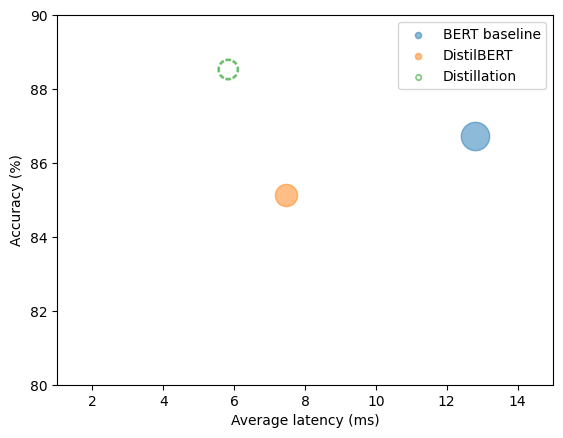

In [ ]:
plot_metrics(perf_metrics, optim_type)

## Making Models Faster with Quantization

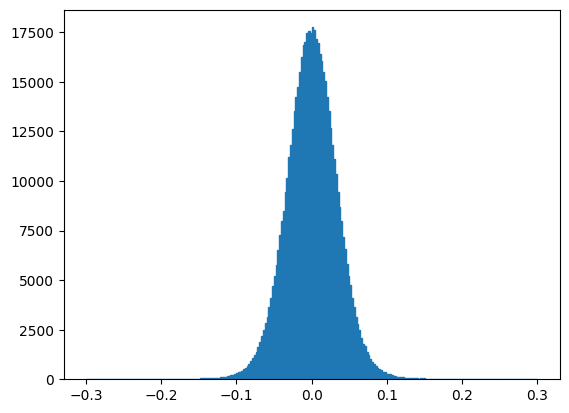

In [ ]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]

plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3, 0.3), edgecolor="C0")
plt.show();

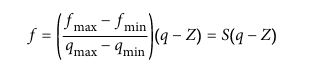

In [ ]:
# convert the float into 8bit int
# that mean qmax, qmin == 127, -128 -> range of 8bit int
# and for fmax and fmin == max(wieghts), min(weights)

Z = 0 # A constant
scale = (weights.max() - weights.min()) / (127 - (-128))
scale

tensor(0.0053)

image.png

In [ ]:
# f = S(q-Z)
# Where f = floating point weights/tensors
#       S = scale
#       q = quantized tensor
#       Z = Constant

# SO to gat q
# we have = q = f/S + Z

(weights / scale + Z).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -8,  -5,   5,  ...,   0,   6,  -4],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], dtype=torch.int8)

In [ ]:
weights

tensor([[-0.0272, -0.0411, -0.0004,  ..., -0.0334, -0.0202,  0.0415],
        [ 0.0457,  0.0139,  0.0077,  ..., -0.0221,  0.0392,  0.0014],
        [-0.0439, -0.0288,  0.0289,  ...,  0.0024,  0.0293, -0.0200],
        ...,
        [ 0.0315,  0.0007,  0.0671,  ..., -0.0015,  0.0324, -0.0043],
        [ 0.0022, -0.0124, -0.0631,  ...,  0.0633, -0.0388, -0.0699],
        [-0.0669, -0.0063, -0.0487,  ...,  0.0424,  0.0130, -0.0064]])

In [ ]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, Z, dtype)
quantized_weights.int_repr() # by calling int_repr the weights got converted into int tensors


tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -8,  -5,   5,  ...,   0,   6,  -4],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], dtype=torch.int8)

In [ ]:
# MEasure how fast the q tensors are for prformance

%%timeit
weights @ weights

22.7 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [ ]:
%%timeit
q_fn.mal(quantized_weights, quantized_weights)

TypeError: QFunctional.forward() takes 2 positional arguments but 3 were given

In [ ]:
?QFunctional

TypeError: Got unsupported ScalarType QInt8

In [ ]:
from torch.quantization import quantize_dynamic
model_ckpt = "aman155/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt).to("cpu"))
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

In [ ]:
pipe = pipeline("text-classification", model=model_quantized,
tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

## ONNX

In [ ]:
import os
from psutil import cpu_count

In [ ]:
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = f"ACTIVE"

In [ ]:
cpu_count()

2

In [ ]:
from transformers.convert_graph_to_onnx import convert

model_ckpt =